# Qaintellect implementation of the Warm-Start Quantum Optimization Algorithm (WS-QAOA)

In this example, we implement the optimization of a circuit based on the QAOA algorithm using a warm-start, demonstrated via the Max-Cut problem. Ideally the warm start is close to the optimal solution, which would lead to faster and better convergence than using normal QAOA.

Reference:
- Egger, Daniel J., Jakub Mareček, and Stefan Woerner “Warm-starting quantum optimization” Quantum 5 (Junie 2021): 479. [doi:10.22331](https://doi.org/10.22331/q-2021-06-17-479E) (2021)

In [1]:
using Qaintessent
using Qaintessent.MaxCutWSQAOA
using Qaintessent.MaxKColSubgraphQAOA
using Qaintessent.QAOAHelperDataStructs
using Qaintellect
using LinearAlgebra
using Flux
using IterTools: ncycle
using MaxCut

In [2]:
# visualization
using Plots
using LaTeXStrings

In [3]:
# number of vertices
n = 5

# graph edges corresponding to the above graph
edges = [(1, 2), (2, 3), (2, 4), (3, 5), (4, 5)];

weighted_edges = [(1, 2, 5.0), (2, 3, 3.0), (2, 4, -2.0), (3, 5, 4.0), (4, 5, -4.0)]

# graph struct that is implemented in QAOAHelperDataStructs
graph = Graph(n, edges)

edge_weighted_graph = EdgeWeightedGraph(n, weighted_edges)
adj_mat = adjacency_matrix(edge_weighted_graph)
# max_cut, max_partition = maxcut(adj_mat, iter=2)

5×5 Matrix{Int64}:
 0   5  0   0   0
 5   0  3  -2   0
 0   3  0   0   4
 0  -2  0   0  -4
 0   0  4  -4   0

In [35]:
function ws_qaoa_maxcut_circuit(γs::Vector{Float64}, βs::Vector{Float64}, ws_partitioning::Vector{Float64}, 
        graph::EdgeWeightedGraph, ε::Float64, init_state_randomized::Bool)
    gates::Vector{CircuitGate} = []
    # ws-qaoa circuit
    for (γ, β) in zip(γs, βs)
        # Add the phase separation gate
        phase_separation_gate =  MaxCutPhaseSeparationGate(γ, graph)
        push!(gates, CircuitGate(Tuple(1:graph.n), phase_separation_gate))
        # Add WS-MaxCut Mixer
        mixer_gate = WSQAOAMixerGate(β, ws_partitioning, ε, init_state_randomized)
        # mixer_gate = RxMixerGate(β, graph.n)
        push!(gates, CircuitGate(Tuple(1:graph.n), mixer_gate))
    end
    # One-hot encoding: each qubit represents one node exactly
    Circuit{graph.n}(gates)
end

ws_qaoa_maxcut_circuit (generic function with 2 methods)

In [4]:
# Define the warm-start position
# Ideally, this should come from a fast classical approximation algorithm
# i.e: for MaxCut one can use the GW-algorithm
# this partitioning has cut size 4, optimal cut size in this case is 5
ws_partitioning = [0.0, 0.0, 0.0, 0.0, 0.0] 
ws = kron((ws_partitioning[i] == 0 ? [1.0, 0.0im] : [0.0im, 1.0] for i in 1:length(ws_partitioning))...)
ε = 0.5 # regularization parameter
init_state_randomized = false # if true, traverse from the direction to be able to represent all solution space
p = 4 # circuit depth
initial_γs = rand(p) #2 * π randn(p) # p phase separators p parameters
initial_βs = rand(p) #2 * π * randn(p) # p mixer gates, same as γ

4-element Vector{Float64}:
 0.5442504829482648
 0.9391701330672015
 0.8458248636994756
 0.31690144448741564

In [36]:
circuit = ws_qaoa_maxcut_circuit(initial_γs, initial_βs, ws_partitioning, to_edge_weighted_graph(graph), ε, init_state_randomized)


    8 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    2 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    1 ——□—————□—————□—————□—————□—————□—————□—————□———


In [37]:
function prepare_init_state(ws_partitioning::Vector{Float64}, ε::Float64)
    gates::Vector{CircuitGate} = []
    n = length(ws_partitioning)
    # prepare the initial state
    for i in eachindex(ws_partitioning)
        # calculate theta according to regularization parameter and partitioning: Sec. (2.2)
        c_i = ws_partitioning[i]
        c_i = c_i <= ε ? ε : c_i
        c_i = c_i >= (1 - ε) ? (1 - ε) : c_i
        theta_i = 2 * asin(sqrt(c_i))
        push!(gates, CircuitGate(Tuple(i,), RyGate(theta_i)))
    end
    init_circ = Circuit{n}(gates)
    # starting point: |0>
    start_point = zeros(ComplexF64, 2^n)
    start_point[1] = 1.0 + 0.0im
    return apply(start_point, init_circ.moments)
end

prepare_init_state (generic function with 1 method)

In [38]:
init_state = prepare_init_state(ws_partitioning, 0.5)

256-element Vector{ComplexF64}:
  0.06249999999999996 + 0.0im
  0.06249999999999997 + 0.0im
  0.06249999999999997 + 0.0im
  0.06249999999999998 + 0.0im
  0.06249999999999997 + 0.0im
  0.06249999999999998 + 0.0im
  0.06249999999999998 + 0.0im
 0.062499999999999986 + 0.0im
  0.06249999999999997 + 0.0im
  0.06249999999999998 + 0.0im
  0.06249999999999998 + 0.0im
 0.062499999999999986 + 0.0im
  0.06249999999999998 + 0.0im
                      ⋮
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im
  0.06250000000000001 + 0.0im

In [130]:
function optimize_ws_qaoa(graph::EdgeWeightedGraph, ws_partitioning::Vector{Float64}, ε::Float64, init_state_randomized::Bool, 
        p::Int, training_rounds::Int=10, learning_rate::Float64=0.005, 
        init_stddev=1, logger::Any=nothing)
    ((isnothing(p) || p > 0) && training_rounds > 0) ||
        throw(DomainError("`p` and `training_rounds` must be positive integers."))
    # Initialize circuit and wavefunction
    (initial_γs, initial_βs) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
    circ = ws_qaoa_maxcut_circuit(initial_γs, initial_βs, ws_partitioning, graph, ε, init_state_randomized)
    ws = prepare_init_state(ws_partitioning, ε)
    H_P_diag = diag(max_cut_phase_separation_hamiltonian(graph)) # can't have `Diagonal` matrix type here (error in backprop)
    # Set up optimization with Flux
    params = Flux.params(circ)
    data = repeat([()], training_rounds) # empty input data for `training_rounds` rounds of training
    optimizer = ADAM(learning_rate)
    objective = real(ws' * (H_P_diag .* ws))
    println("Training, round 0: average objective = $(objective)")
    round = 1
    # evaluate expectation <f> to be minimized and print it
    expectation() = begin
        par = Flux.params(circ)
        ws_out = apply(ws, circ.moments)
        objective = real(ws_out' * (H_P_diag .* ws_out))
        println("Training, round $(round): average objective=$(objective)")
        if !isnothing(logger)
            log_qaoa(logger, round, ws_out, objective, params)
        end
        round += 1
        return -objective
    end
    
    # Perform training
    Flux.train!(expectation, params, data, optimizer)
    return circ
end

optimize_ws_qaoa (generic function with 21 methods)

In [179]:
function recursive_ws_qaoa(graph::EdgeWeightedGraph, ws_partitioning::Vector{Float64}, ε::Float64, init_state_randomized::Bool, 
        p::Int, training_rounds::Int=10, learning_rate::Float64=0.01, 
        init_stddev=1, logger::Any=nothing) where {N}
    if graph.n <= 3 || length(graph.edges) <= 1
        # Initialize circuit and wavefunction
        println("End of recursion!")
        res = maxcut(adjacency_matrix(graph))
        println("res: $(res)")
        return res
    end
    ws = prepare_init_state(ws_partitioning, ε)
    opt_circ = optimize_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, training_rounds, learning_rate, init_stddev, logger)
    ws_out = apply(ws, opt_circ.moments)
    (max_corr, corr_edge) = (0, (-1, -1))
    for (edge, w) in graph.edges
        correlator =  kron((i ∈ edge ? matrix(Z) : I(2) for i in 1:graph.n)...)
        corr = ws_out' * correlator * ws_out
        if abs(corr) >= abs(max_corr)
            max_corr = corr
            corr_edge = edge
        end
    end
    (v_out, v_k) = corr_edge
    adj_mat = adjacency_matrix(graph)
    reduced_edges::Vector{Tuple{Int, Int, Float64}} = []
    # replace v_out with sign(max_corr)*v_k
    for (edge, w) in graph.edges
        if !(v_out ∈ edge) 
            (v_i, v_j) = edge
            v_i_updated = v_i > v_out ? v_i - 1 : v_i
            v_j_updated = v_j > v_out ? v_j - 1 : v_j
            extra_weight = 0.0
            if v_i == v_k
                extra_weight = sign(max_corr) * adj_mat[v_j, v_out]
            elseif v_j == v_k
                extra_weight = sign(max_corr) * adj_mat[v_i, v_out]
            else
                extra_weight = 0.0
            end
            push!(reduced_edges, (v_i_updated, v_j_updated, w + real(extra_weight)))
        end
    end
    reduced_graph = EdgeWeightedGraph(graph.n - 1, reduced_edges)
    reduced_partitioning = ws_partitioning[1:graph.n .!= v_out]
    (cut_size, partitions) = recursive_ws_qaoa(reduced_graph, reduced_partitioning, ε, 
        init_state_randomized, p, training_rounds, learning_rate, init_stddev, logger)
    (partition1, partition2) = partitions
    println("return from recursion")
    println("partitions: $(partitions)")
    println("v_out: $(v_out)")
    for i in 1:length(partition1)
        partition1[i] = partition1[i] >= v_out ? partition1[i] + 1 : partition1[i]
    end
    for i in 1:length(partition2)
        partition2[i] = partition2[i] >= v_out ? partition2[i] + 1 : partition2[i]
    end
    if v_k ∈ partition1
        if real(sign(max_corr)) <= 0
            push!(partition2, v_out)
        else
            push!(partition1, v_out)
        end
    else
        if real(sign(max_corr)) <= 0
            push!(partition1, v_out)
        else
            push!(partition2, v_out)
        end
    end
    return (cut_size, (partition1, partition2))
end

recursive_ws_qaoa (generic function with 15 methods)

In [185]:
n = 8
edges = [(1, 2), (1, 4), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (4, 8), (5, 6), (5, 8), (6, 7), (7, 8)];
graph = Graph(n, edges)
ws_partitioning = [0.0, 0.0, 0.0, 0.0, 0.0 ,0.0, 0.0, 0.0]
ε = 0.25
init_state_randomized = true
p = 6
rounds = 30
ws = prepare_init_state(ws_partitioning, ε)
lr = 0.1
(max_cut, max_partition) = maxcut(adj_mat, iter=1)

(12, ([2, 4, 5, 7], [1, 3, 6, 8]))

In [188]:
circ_opt = optimize_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, 0.5, true, 6, 80, 0.1)


Training, round 0: average objective = 6.0
Training, round 1: average objective=6.081647208777859
Training, round 2: average objective=6.975628537990044
Training, round 3: average objective=7.143951571565757
Training, round 4: average objective=7.755102256426588
Training, round 5: average objective=8.2542475317885
Training, round 6: average objective=8.346169081762739
Training, round 7: average objective=8.446149627089138
Training, round 8: average objective=8.507708286920252
Training, round 9: average objective=8.945564692179449
Training, round 10: average objective=9.444061147253413
Training, round 11: average objective=9.606620859300431
Training, round 12: average objective=9.41880722841529
Training, round 13: average objective=9.408684986649625
Training, round 14: average objective=9.643435195887484
Training, round 15: average objective=9.670597455008624
Training, round 16: average objective=9.706051231289043
Training, round 17: average objective=9.931553280107897
Training, round 1


    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |   
    2 ——□—————□—————□—————□—————□—————□—————□—————□

In [186]:
ws_rqaoa_result = recursive_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 4.499999999999999
Training, round 1: average objective=6.343590482365888
Training, round 2: average objective=7.119187114336208
Training, round 3: average objective=7.5649978707206165
Training, round 4: average objective=8.046077405832328
Training, round 5: average objective=8.266411114550266
Training, round 6: average objective=7.986418074669383
Training, round 7: average objective=8.291205774739064
Training, round 8: average objective=8.662846070150886
Training, round 9: average objective=8.522988037846561
Training, round 10: average objective=8.547089908950587
Training, round 11: average objective=8.771090500074742
Training, round 12: average objective=8.885254037584197
Training, round 13: average objective=8.764176739906441
Training, round 14: average objective=8.794147518459512
Training, round 15: average objective=8.968627682597429
Training, round 16: average objective=9.023678548944025
Training, round 17: average objective=8.987416714325002

(0, ([1, 7, 4], [3, 6, 8, 5, 2]))

In [183]:
# Example graph with negative/positive edge weights, shown at: Fig (9)
edges = [
    (1, 2, 3.0), (1, 3, 3.0), (1, 4, 6.0), (1, 5, 9.0), (1, 6, 1.0),
    (2, 3, 4.0), (2, 4, 4.0), (2, 5, -8.0), (2, 6, 4.0),
    (3, 4, 3.0), (3, 5, -7.0), (3, 6, 1.0),
    (4, 5, -7.0), (4, 6, 6.0),
    (5, 6, -5.0)
]
n = 6
graph = EdgeWeightedGraph(n, edges)
ws_partitioning = [0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
ε = 0.25
init_state_randomized = true
p = 20
rounds = 300
ws = prepare_init_state(ws_partitioning, ε)

64-element Vector{ComplexF64}:
  0.04687500000000004 + 0.0im
 0.027063293868263734 + 0.0im
 0.027063293868263734 + 0.0im
 0.015625000000000014 + 0.0im
  0.08118988160479115 + 0.0im
  0.04687500000000003 + 0.0im
  0.04687500000000003 + 0.0im
 0.027063293868263727 + 0.0im
  0.08118988160479115 + 0.0im
 0.046875000000000035 + 0.0im
 0.046875000000000035 + 0.0im
 0.027063293868263727 + 0.0im
  0.14062500000000003 + 0.0im
                      ⋮
  0.24356964481437335 + 0.0im
             0.140625 + 0.0im
             0.140625 + 0.0im
  0.08118988160479113 + 0.0im
  0.24356964481437335 + 0.0im
             0.140625 + 0.0im
             0.140625 + 0.0im
  0.08118988160479113 + 0.0im
   0.4218749999999999 + 0.0im
  0.24356964481437332 + 0.0im
  0.24356964481437332 + 0.0im
  0.14062499999999997 + 0.0im

In [102]:
circ_opt = optimize_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds)

Training, round 0: average objective = 6.125000000000001
Training, round 1: average objective=9.568149456641102
Training, round 2: average objective=10.678584416950834
Training, round 3: average objective=11.25723106207067
Training, round 4: average objective=11.698976121878914
Training, round 5: average objective=12.237879419359679
Training, round 6: average objective=12.788905255164357
Training, round 7: average objective=13.24548069313503
Training, round 8: average objective=13.633386531085891
Training, round 9: average objective=14.039788145811531
Training, round 10: average objective=14.503823531389218
Training, round 11: average objective=14.982802530689458
Training, round 12: average objective=15.421371252610426
Training, round 13: average objective=15.810441936792197
Training, round 14: average objective=16.162686987571657
Training, round 15: average objective=16.445684970096195
Training, round 16: average objective=16.612957439062185
Training, round 17: average objective=16.69

Training, round 144: average objective=22.22327568015735
Training, round 145: average objective=22.223690886656748
Training, round 146: average objective=22.22407487762255
Training, round 147: average objective=22.22443933757239
Training, round 148: average objective=22.224793962536673
Training, round 149: average objective=22.225144118637008
Training, round 150: average objective=22.225493211046093
Training, round 151: average objective=22.225842063086382
Training, round 152: average objective=22.22619043287412
Training, round 153: average objective=22.226536860248004
Training, round 154: average objective=22.226878750471993
Training, round 155: average objective=22.227212830945245
Training, round 156: average objective=22.22753582959696
Training, round 157: average objective=22.227845119454667
Training, round 158: average objective=22.228138342322183
Training, round 159: average objective=22.22841382072468
Training, round 160: average objective=22.22867021186834
Training, round 161: 

Training, round 287: average objective=22.232617099911074
Training, round 288: average objective=22.232617935696233
Training, round 289: average objective=22.232618737158454
Training, round 290: average objective=22.23261950569722
Training, round 291: average objective=22.232620244020133
Training, round 292: average objective=22.232620952524762
Training, round 293: average objective=22.232621631551616
Training, round 294: average objective=22.232622282479973
Training, round 295: average objective=22.232622906036024
Training, round 296: average objective=22.23262350462821
Training, round 297: average objective=22.232624077657565
Training, round 298: average objective=22.23262462734443
Training, round 299: average objective=22.232625153838512
Training, round 300: average objective=22.232625656408118



    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□——

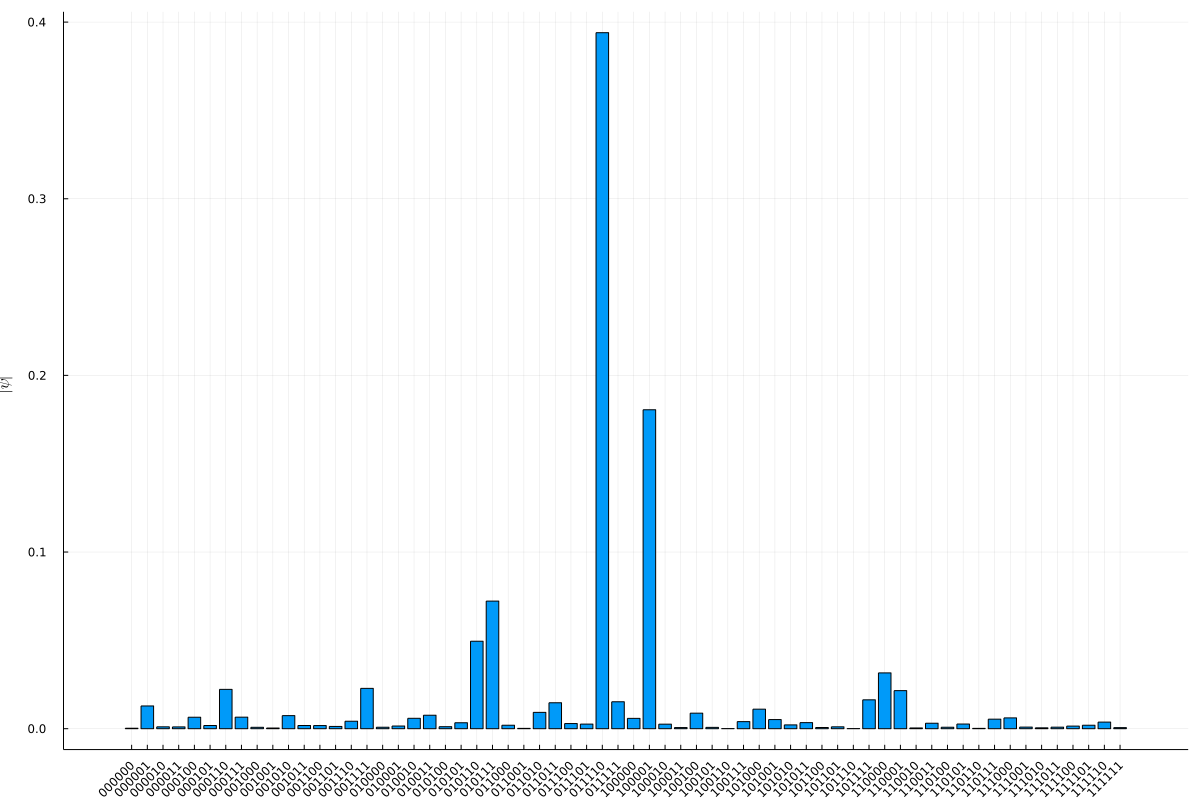

In [103]:
result = apply(ws, circ_opt.moments)

tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(result), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(1200, 800))